In [0]:
# Importing necessary paackages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
import string

from sklearn.model_selection import train_test_split,KFold
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
import xgboost as xgb 
seed = 4353

In [0]:
#Text processing requisites
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [0]:
#Load train and test data for Product Reviews Analysis
train = pd.read_csv('train_data.csv')
test = pd.read_csv('test_data.csv')

In [0]:
print('Number of rows and columns in train data set',train.shape) 

Number of rows and columns in train data set (4000, 8)


In [0]:
# Convert column names to uppercase
train.columns = train.columns.str.upper()

In [0]:
train.head()

,NAME,BRAND,CATEGORIES,PRIMARYCATEGORIES,REVIEWS.DATE,REVIEWS.TEXT,REVIEWS.TITLE,SENTIMENT
0,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2016-12-26T00:00:00.000Z,Purchased on Black FridayPros - Great Price (e...,Powerful tablet,Positive
1,Amazon - Echo Plus w/ Built-In Hub - Silver,Amazon,"Amazon Echo,Smart Home,Networking,Home & Tools...","Electronics,Hardware",2018-01-17T00:00:00.000Z,I purchased two Amazon in Echo Plus and two do...,Amazon Echo Plus AWESOME,Positive
2,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Amazon Echo,Virtual Assistant Speakers,Electro...","Electronics,Hardware",2017-12-20T00:00:00.000Z,Just an average Alexa option. Does show a few ...,Average,Neutral
3,"Fire HD 10 Tablet, 10.1 HD Display, Wi-Fi, 16 ...",Amazon,"eBook Readers,Fire Tablets,Electronics Feature...","Office Supplies,Electronics",2017-08-04T00:00:00.000Z,"very good product. Exactly what I wanted, and ...",Greattttttt,Positive
4,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2017-01-23T00:00:00.000Z,This is the 3rd one I've purchased. I've bough...,Very durable!,Positive


In [0]:
print('Number of rows and columns in test data set',test.shape)
test.columns = test.columns.str.upper()
test.head()

Number of rows and columns in test data set (1000, 8)


,NAME,BRAND,CATEGORIES,PRIMARYCATEGORIES,REVIEWS.DATE,REVIEWS.TEXT,REVIEWS.TITLE,SENTIMENT
0,"Fire Tablet, 7 Display, Wi-Fi, 16 GB - Include...",Amazon,"Fire Tablets,Computers/Tablets & Networking,Ta...",Electronics,2016-05-23T00:00:00.000Z,Amazon kindle fire has a lot of free app and c...,very handy device,Positive
1,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2018-01-02T00:00:00.000Z,The Echo Show is a great addition to the Amazo...,Another winner from Amazon,Positive
2,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-01-02T00:00:00.000Z,Great value from Best Buy. Bought at Christmas...,simple to use and reliable so far,Positive
3,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2017-03-25T00:00:00.000Z,"I use mine for email, Facebook ,games and to g...",Love it!!!,Positive
4,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2017-11-15T00:00:00.000Z,This is a fantastic item & the person I bought...,Fantastic!,Positive


In [0]:
# Check for any missing values in the training dataset
train.isnull().sum()

NAME                  0
BRAND                 0
CATEGORIES            0
PRIMARYCATEGORIES     0
REVIEWS.DATE          0
REVIEWS.TEXT          0
REVIEWS.TITLE        10
SENTIMENT             0
dtype: int64

In [0]:
#Records corresponding to entries from training dataset in 'REVIEWS.TITLE' column with missing values
train[train['REVIEWS.TITLE'].isnull() == True]

,NAME,BRAND,CATEGORIES,PRIMARYCATEGORIES,REVIEWS.DATE,REVIEWS.TEXT,REVIEWS.TITLE,SENTIMENT
834,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2017-12-29T16:56:05.000Z,Best New Adult Toy in years! Wish I had purcha...,NaN,Positive
1268,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Amazon Echo,Virtual Assistant Speakers,Electro...","Electronics,Hardware",2017-12-29T16:56:05.000Z,Best New Adult Toy in years! Wish I had purcha...,NaN,Positive
1695,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2018-09-01T19:51:34.000Z,I bought the echo show for my mom for her birt...,NaN,Positive
1824,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2018-06-06T20:46:55.000Z,"this is pretty cool, we love ours, we listen t...",NaN,Positive
2786,Amazon Fire TV with 4K Ultra HD and Alexa Voic...,Amazon,"Amazon SMP,TV, Video & Home Audio,Electronics,...",Electronics,2017-11-30T21:40:30.000Z,Really cool device! Instantly noticed the diff...,NaN,Positive
2822,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2018-08-16T23:06:42.000Z,I love the Echo show. I have found so many use...,NaN,Positive
2933,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Amazon Echo,Virtual Assistant Speakers,Electro...","Electronics,Hardware",2018-01-06T15:03:52.000Z,"Awesome so far. Have used it as alarm clock, s...",NaN,Positive
3103,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Amazon Echo,Virtual Assistant Speakers,Electro...","Electronics,Hardware",2018-04-06T23:51:32.000Z,This was bought for a gift. But it looks nice....,NaN,Positive
3224,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2017-12-30T18:26:19.000Z,Delivered on time and it looked good will hook...,NaN,Positive
3690,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2018-04-06T23:51:32.000Z,This was bought for a gift. But it looks nice....,NaN,Positive


In [0]:
# We shall not drop 'REVIEWS.TITLE' with missing data because we can still get useful information from 'REVIEWS.TEXT'
# Replace 'REVIEWS.TITLE' missing data with an empty string

train['REVIEWS.TITLE'].fillna(" " , inplace=True)

In [0]:
#Check if the sentiment outcomes are balanced / imbalanced
Sentiment_Counts = train['SENTIMENT'].value_counts()
Sentiment_Counts

Positive    3749
Neutral      158
Negative      93
Name: SENTIMENT, dtype: int64

The training dataset is imbalanced

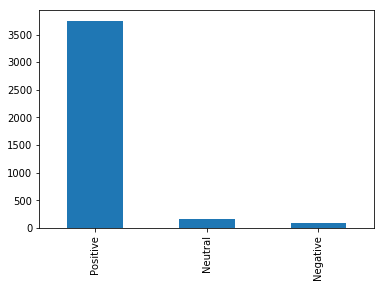

In [0]:
#Visualization using Bar plot (matplotlib)
Sentiment_Counts.plot(kind= 'bar')

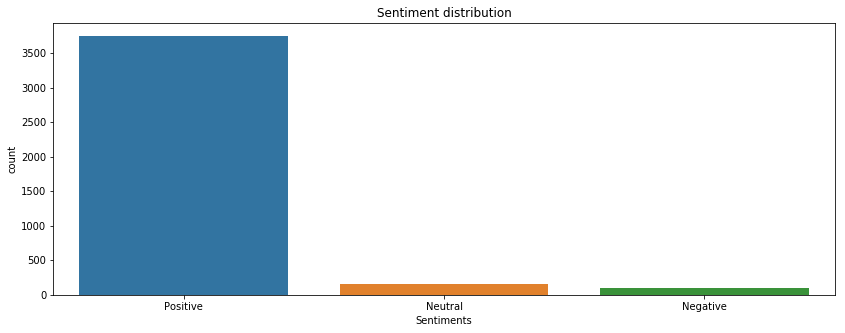

In [0]:
#Visualization using Bar plot (seaborn)
plt.figure(figsize=(14,5))
sns.countplot(train['SENTIMENT'],)
plt.xlabel('Sentiments')
plt.title('Sentiment distribution')
plt.show()

In [0]:
#Check for missing values in test data
test.isnull().sum()

NAME                 0
BRAND                0
CATEGORIES           0
PRIMARYCATEGORIES    0
REVIEWS.DATE         0
REVIEWS.TEXT         0
REVIEWS.TITLE        3
SENTIMENT            0
dtype: int64

In [0]:
# Replace 'REVIEWS.TITLE' missing data with an empty string
test['REVIEWS.TITLE'].fillna(" " , inplace=True)

In [0]:
#Creating Train and Test datasets with only the product reviews (Complete Review = Review Text + Review Title)

X_train = train['REVIEWS.TEXT'] + ' ' + train['REVIEWS.TITLE']
y_train = train['SENTIMENT']


In [0]:
X_test = test['REVIEWS.TEXT'] + ' ' + test['REVIEWS.TITLE']
y_test = test['SENTIMENT']

In [0]:
X_train[0]

'Purchased on Black FridayPros - Great Price (even off sale)Very powerful and fast with quad core processors Amazing soundWell builtCons -Amazon ads, Amazon need this to subsidize the tablet and will remove the adds if you pay them $15.Inability to access other apps except the ones from Amazon. There is a way which I was able to accomplish to add the Google Play storeNet this is a great tablet for the money Powerful tablet'

In [0]:
X_train_df = pd.DataFrame(data= X_train)
X_train_df.columns = ['Review']
X_train_df.head()

,Review
0,Purchased on Black FridayPros - Great Price (e...
1,I purchased two Amazon in Echo Plus and two do...
2,Just an average Alexa option. Does show a few ...
3,"very good product. Exactly what I wanted, and ..."
4,This is the 3rd one I've purchased. I've bough...


# Text Preprocessing  

In [0]:
string.punctuation # contains all the punctions which are to be removed from the reviews

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [0]:
def X_final(X_train_data, X_test_data):

  #Function for removing punctuations
  def remove_punctuations_from_string(X_data):
      string1 = X_data.lower() #changing to lower case
      translation_table = dict.fromkeys(map(ord, string.punctuation), ' ') #creating dictionary of punc & None
      string2 = string1.translate(translation_table) #translating 
      return string2

  X_train_data_clear_punct = []
  for i in range(0, len(X_train_data)):
    test_string = remove_punctuations_from_string(X_train_data[i])
    X_train_data_clear_punct.append(test_string)

  X_test_data_clear_punct = []
  for i in range(0, len(X_test_data)):
    test_string = remove_punctuations_from_string(X_test_data[i])
    X_test_data_clear_punct.append(test_string)


  #Function for removing stopwords
  def remove_stopwords_from_string(X_data):
      pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*') #compiling all stopwords.
      string2 = pattern.sub('', X_data) #replacing the occurrences of stopwords
      return string2

  X_train_data_clear_stopwords = []
  for i in range(0, len(X_train_data)):
    test_string = remove_stopwords_from_string(X_train_data_clear_punct[i])
    X_train_data_clear_stopwords.append(test_string)

  X_test_data_clear_stopwords = []
  for i in range(0, len(X_test_data)):
    test_string = remove_stopwords_from_string(X_test_data_clear_punct[i])
    X_test_data_clear_stopwords.append(test_string)


  # Function for Tokenizing words
  def tokenized_words(X_data):
    words = nltk.word_tokenize(X_data)
    return words

  X_train_data_tokenized_words = []
  for i in range(0, len(X_train_data)):
    test_string = tokenized_words(X_train_data_clear_stopwords[i])
    X_train_data_tokenized_words.append(test_string)

  X_test_data_tokenized_words = []
  for i in range(0, len(X_test_data)):
    test_string = tokenized_words(X_test_data_clear_stopwords[i])
    X_test_data_tokenized_words.append(test_string)


  # Function for Lemmatization
  lemmatizer = WordNetLemmatizer()
  def lematized_words(X_data):
    words = lemmatizer.lemmatize(X_data)
    return words

  X_train_data_lematized_words = []
  for i in range(0, len(X_train_data)):
    X_train_data_lematized_word = []
    for j in range(0, len(X_train_data_tokenized_words[i])):
      test_string = lematized_words(X_train_data_tokenized_words[i][j])
      X_train_data_lematized_word.append(test_string)
    X_train_data_lematized = ' '.join(X_train_data_lematized_word)
    X_train_data_lematized_words.append(X_train_data_lematized)

  X_test_data_lematized_words = []
  for i in range(0, len(X_test_data)):
    X_test_data_lematized_word = []
    for j in range(0, len(X_test_data_tokenized_words[i])):
      test_string = lematized_words(X_test_data_tokenized_words[i][j])
      X_test_data_lematized_word.append(test_string)
    X_test_data_lematized = ' '.join(X_test_data_lematized_word)
    X_test_data_lematized_words.append(X_test_data_lematized)


  # Creating the Bag of Words Model
  cv = CountVectorizer(max_features = 1000)

  X_train_data_vector = cv.fit_transform(X_train_data_lematized_words).toarray()
  X_test_data_vector = cv.fit_transform(X_test_data_lematized_words).toarray()


  # Integer counts to weighted TF-IDF scores
  tf = TfidfTransformer()

  X_train_data_tfidf = tf.fit_transform(X_train_data_vector).toarray()
  X_test_data_tfidf = tf.fit_transform(X_test_data_vector).toarray()

  return X_train_data_tfidf, X_test_data_tfidf

# Model Selection

In [0]:
# Taining and testing data to be used in our model
train_X, test_X = X_final(X_train, X_test)

### Multinomial Naive Bayes

In [0]:
MNB = MultinomialNB()

MNB.fit(train_X,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [0]:
predictions = MNB.predict(test_X)

In [0]:
# Model evaluation
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

MNB_f1 = round(f1_score(y_test, predictions, average= 'weighted'), 3)
MNB_accuracy = round((accuracy_score(y_test, predictions) * 100), 2)

print("Accuracy : " , MNB_accuracy , " %")
print("f1_score : " , MNB_f1)

              precision    recall  f1-score   support

    Negative       0.25      0.04      0.07        24
     Neutral       0.08      0.03      0.04        39
    Positive       0.94      0.99      0.96       937

    accuracy                           0.93      1000
   macro avg       0.42      0.35      0.36      1000
weighted avg       0.89      0.93      0.90      1000

[[  1   1  22]
 [  0   1  38]
 [  3  10 924]]
Accuracy :  92.6  %
f1_score :  0.905


### Random Forest Classifier

In [0]:
from sklearn.ensemble import RandomForestClassifier

rfc=RandomForestClassifier(random_state= seed)

In [0]:
rfc=RandomForestClassifier(n_estimators= 10, random_state= seed)

rfc.fit(train_X,y_train)

predictions = rfc.predict(test_X)

# Model evaluation
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

rfc_f1 = round(f1_score(y_test, predictions, average= 'weighted'), 3)
rfc_accuracy = round((accuracy_score(y_test, predictions) * 100), 2)

print("Accuracy : " , rfc_accuracy , " %")
print("f1_score : " , rfc_f1)

              precision    recall  f1-score   support

    Negative       0.17      0.04      0.07        24
     Neutral       0.00      0.00      0.00        39
    Positive       0.94      0.99      0.96       937

    accuracy                           0.93      1000
   macro avg       0.37      0.34      0.34      1000
weighted avg       0.88      0.93      0.90      1000

[[  1   0  23]
 [  0   0  39]
 [  5   5 927]]
Accuracy :  92.8  %
f1_score :  0.904


### XGBoost

In [0]:
xgb_ = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'multi:softmax',
 nthread=4,
 scale_pos_weight=1,
 seed= seed)

In [0]:
xgb_.fit(train_X,y_train)

predictions = xgb_.predict(test_X)

# Model evaluation
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

xgb_f1 = round(f1_score(y_test, predictions, average= 'weighted'), 3)
xgb_accuracy = round((accuracy_score(y_test, predictions) * 100), 2)

print("Accuracy : " , xgb_accuracy , " %")
print("f1_score : " , xgb_f1)

              precision    recall  f1-score   support

    Negative       0.11      0.12      0.12        24
     Neutral       0.08      0.03      0.04        39
    Positive       0.94      0.96      0.95       937

    accuracy                           0.91      1000
   macro avg       0.38      0.37      0.37      1000
weighted avg       0.89      0.91      0.90      1000

[[  3   0  21]
 [  1   1  37]
 [ 23  12 902]]
Accuracy :  90.6  %
f1_score :  0.895


### Support Vector Machine (SVM)

In [0]:
from sklearn import svm

In [0]:
svc = svm.SVC(random_state= seed)

#Using k-fold cross validation technique
kf = KFold(n_splits = 5, random_state= seed)

#Hyperparameter tuning using grid search for SVM

param_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}] #Large Value of parameter C => small margin
                                                                     #Small Value of paramerter C => Large margin

grid = GridSearchCV(estimator= svc, param_grid= param_grid, scoring= 'accuracy', cv= kf)
# fit the train data 
grid.fit(train_X, y_train)

print('Estimator: ', grid.best_estimator_)
print('Best params : \n', grid.best_params_)
print('Output Classes: ', grid.classes_)
print('Training Accuracy: ', grid.best_score_)

Estimator:  SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=4353, shrinking=True,
    tol=0.001, verbose=False)
Best params : 
 {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
Output Classes:  ['Negative' 'Neutral' 'Positive']
Training Accuracy:  0.9475


In [0]:
# Predictions on test data
predictions = grid.predict(test_X)

# Model evaluation
print(classification_report(y_true= y_test, y_pred= predictions))

svc_f1 = round(f1_score(y_test, predictions, average= 'weighted'), 3)
svc_accuracy = round((accuracy_score(y_test, predictions) * 100), 2)

print("Accuracy : " , svc_accuracy , " %")
print("f1_score : " , svc_f1)

              precision    recall  f1-score   support

    Negative       0.06      0.04      0.05        24
     Neutral       0.00      0.00      0.00        39
    Positive       0.94      0.98      0.96       937

    accuracy                           0.92      1000
   macro avg       0.33      0.34      0.34      1000
weighted avg       0.88      0.92      0.90      1000

Accuracy :  91.7  %
f1_score :  0.898


### LSTM --> Long Short Term Memory Implementation

In [0]:
from keras import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

embedding_size =32
max_words = 5000

model=Sequential()
model.add(Embedding(max_words, embedding_size, input_length= train_X.shape[1]))
model.add(LSTM(100))
model.add(Dense(3, activation='softmax'))

print(model.summary())

Using TensorFlow backend.





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 32)          160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 303       
Total params: 213,503
Trainable params: 213,503
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
model.compile(loss='categorical_crossentropy', 
             optimizer='adam', 
             metrics=['accuracy'])

In [0]:
#Converting y_train categorical labels to numbers
y_train_dummies = pd.get_dummies(y_train).values
print('Shape of label tensor:', y_train_dummies.shape)

Shape of label tensor: (4000, 3)


In [0]:
#Train the model
model.fit(train_X, y_train_dummies, epochs= 5, batch_size= 32) 

model.save('AmazonProductReview.h5')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/5





4000/4000 [==============================] - 121s 30ms/step - loss: 0.3481 - acc: 0.9297
Epoch 2/5
4000/4000 [==============================] - 120s 30ms/step - loss: 0.2798 - acc: 0.9373
Epoch 3/5
4000/4000 [==============================] - 121s 30ms/step - loss: 0.2798 - acc: 0.9373
Epoch 4/5
4000/4000 [==============================] - 122s 30ms/step - loss: 0.2778 - acc: 0.9373
Epoch 5/5
4000/4000 [==============================] - 122s 30ms/step - loss: 0.2768 - acc: 0.9373


In [0]:
#Converting y_test categorical labels to numbers
y_test_dummies = pd.get_dummies(y_test).values
print('Shape of label tensor:', y_test_dummies.shape)

Shape of label tensor: (1000, 3)


In [0]:
# Model evaluation
from keras.models import load_model

model_ = load_model('AmazonProductReview.h5')
scores = model_.evaluate(test_X, y_test_dummies)

LSTM_accuracy = scores[1] * 100
print('Test accuracy:', scores[1] * 100, ' %')

1000/1000 [==============================] - 5s 5ms/step
Test accuracy: 93.7  %


# Model Comparision

In [0]:
model = ['MNB', 'Random Forest', 'XGBoost', 'SVM', 'LSTM']
acc = [MNB_accuracy, rfc_accuracy, xgb_accuracy, svc_accuracy, LSTM_accuracy]

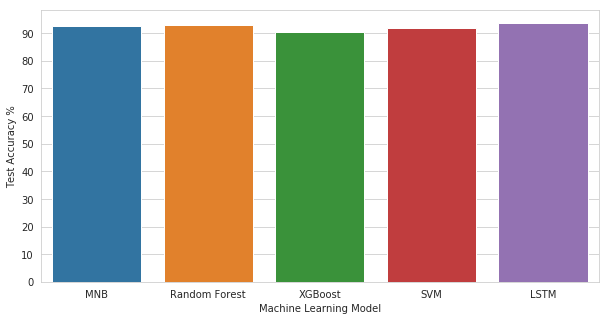

In [0]:
#Comapring the accuracy for various models
sns.set_style("whitegrid")
plt.figure(figsize=(10,5))
plt.yticks(np.arange(0,100,10))
plt.ylabel("Test Accuracy %")
plt.xlabel("Machine Learning Model")
sns.barplot(x= model, y= acc)
plt.show()

Accuracy is not considered to be a good metric for assessing the model’s performance when the dataset is imbalanced.


f1-score is a good metric for assessing the model’s performance when the dataset is imbalanced. The f1-score combines the precision and recall using the harmonic mean.

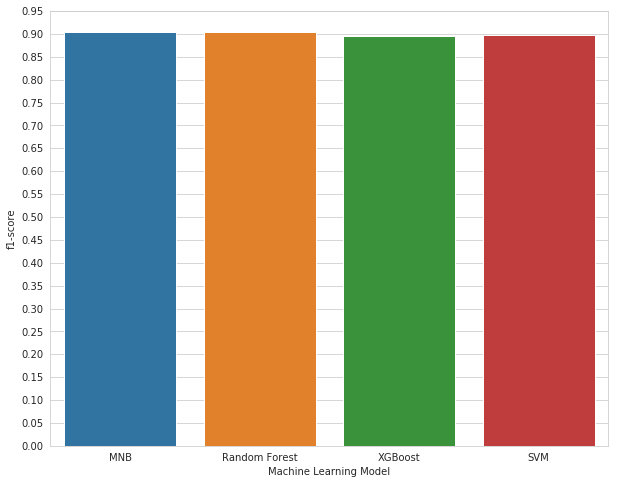

In [0]:
# Comparing the f1-score for various models
model = ['MNB', 'Random Forest', 'XGBoost', 'SVM']
f1_score = [MNB_f1, rfc_f1, xgb_f1, svc_f1]

sns.set_style("whitegrid")
plt.figure(figsize=(10,8))
plt.yticks(np.linspace(0,1,21))
plt.ylabel("f1-score")
plt.xlabel("Machine Learning Model")
sns.barplot(x= model,  y= f1_score)
plt.show()